# Introduction

This is the first notebook in the journey of learning about Financial Analytics on Cryptocurrencies. Exciting! The author will come back to this occasionally and update this list of references that help us navigating the rough seaas of cryptocurrency price analytics:

- James Ma Weiming. “Mastering Python for Finance - Second Edition.” 

- YouTube channel of Benjamin Cowen (https://www.youtube.com/channel/UCRvqjQPSeaWn-uEx-w0XOIg)

- Udemy course Python for Finance: Investment Fundamentals & Data Analytics (https://www.udemy.com/course/python-for-finance-investment-fundamentals-data-analytics/)

# Get cryptocurrency prices

We can find information on cryptocurrency prices on exchanges or datasets for example on kaggle. A popular exchange is coinmarketcap where historical price information is available via an API. See the documentation on coinmarketcap for details of how to extract prices using Python.

Let us import bitcoin below. The author has downloaded cryptocurrency price information using the coinmarketcap API.

In [86]:
import pandas as pd
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
import seaborn as sns
set_matplotlib_formats('svg')

folder = f'../02.Prepared_data/2021-04-05'
BTC = pd.read_csv(f"{folder}/BTC_Bitcoin.csv", index_col=0, parse_dates=['date'])
BTC = BTC.sort_values(by='date')
BTC = BTC.set_index('date', drop=True)
BTC.head()

,open,high,low,close,volume,market_cap
date,,,,,,
2013-04-29,134.44,147.49,134.00,144.54,0.0,1.603769e+09
2013-04-30,144.00,146.93,134.05,139.00,0.0,1.542813e+09
2013-05-01,139.00,139.89,107.72,116.99,0.0,1.298955e+09
2013-05-02,116.38,125.60,92.28,105.21,0.0,1.168517e+09
2013-05-03,106.25,108.13,79.10,97.75,0.0,1.085995e+09


# Time Series Data Financial Analytics

## Plotting a candlestick chart

A candlestick chart is chart with a tick at each particular point of time with four important pieces of information: the open, the high, the low, and the close of the price. In the case of cryptocurrencies, this is daily information (weekends are also trading days). The small whiskers are the highs and low. The candle is red when the closing price was below the opening price and vice versa (then it would be a green color). This is fairly intuitive to understand.

In [50]:
fig = go.Figure(data=[go.Candlestick(x=BTC.index,
                open=BTC['open'], high=BTC['high'],
                low=BTC['low'], close=BTC['close'])
                     ])

# fig.update_yaxes(type="log")
# fig.update_layout(xaxis_rangeslider_visible=False)
fig.show()

## Plotting returns 
Conveniently, pandas has a function `pct_change` to calculate the percentage change between two rows. In the case below, this corresponds to the daily percentage change in price for bitcoin.

In [51]:
BTC.pct_change(periods=1).tail()

,open,high,low,close,volume,market_cap
date,,,,,,
2021-03-28,0.015187,0.000744,0.015268,-0.000407,0.008887,-0.000352
2021-03-29,-0.000483,0.030591,0.001239,0.032161,0.208424,0.032210
2021-03-30,0.032213,0.018942,0.038307,0.020216,-0.055730,0.020269
2021-03-31,0.020435,0.008122,0.008294,0.000019,0.204114,0.000070
2021-04-01,-0.000063,-0.005739,0.013492,0.003004,-0.058785,0.003055


We can chose to plot a line plot of the daily returns, but the resulting graph will by very scattered, instead it makes more sense to look at a histogram of the daily returns.

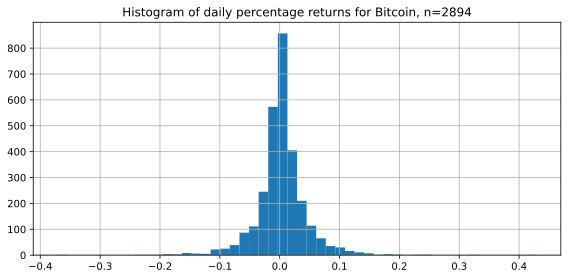

In [64]:
BTC.pct_change(periods=1).loc[:, 'close'].hist(bins=50, figsize=(8, 4));
plt.title(f'Histogram of daily percentage returns for Bitcoin, n={BTC.shape[0]-1}')
plt.tight_layout()
plt.show()

The distribution appears fairly symmetric. If we use the `describe` method of pandas dataframe, we can see that the daily returns are centered around almost zero (but slightly positive with 0.002981), and values range from about -37% through +43%. The 75% quantile is about 2%. 

In [63]:
BTC.pct_change(periods=1).loc[:, 'close'].describe()

count    2894.000000
mean        0.002981
std         0.042422
min        -0.371695
25%        -0.012412
50%         0.001922
75%         0.018640
max         0.429680
Name: close, dtype: float64

## Volatility

The standard deviation can be use to express the volatility of a security. By itself, the standard deviation is the measure of dispersion around the mean.

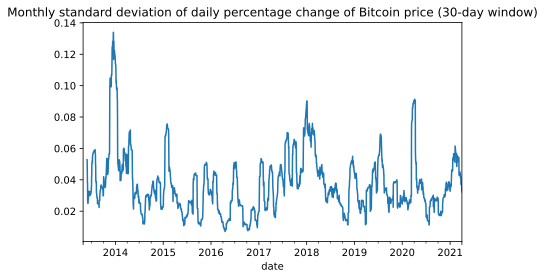

In [65]:
df = BTC['close']
df = df.pct_change()
df_std = df.rolling(window=30, min_periods=30).std()
df_std.plot()
plt.title('Monthly standard deviation of daily percentage change of Bitcoin price (30-day window)')
plt.tight_layout()
plt.show()

The `rolling` method of pandas is used here to create a window of size 30 (i.e., 30 days, 1 month) and calculate the volalitity (expressed as the standard deviation) the bitcoin price over the time series.

## Q-Q Plot

A Q-Q (quantile-quantile) plot is a probability distribution plot, where the quantiles of two distributions are plotted against each other. If the distributions are linearly related, the points in the Q-Q plot will lie along a line. Compared to histograms, Q-Q plots help us to visualize points that lie outside the line for positive and negative skews, as well as excess kurtosis.

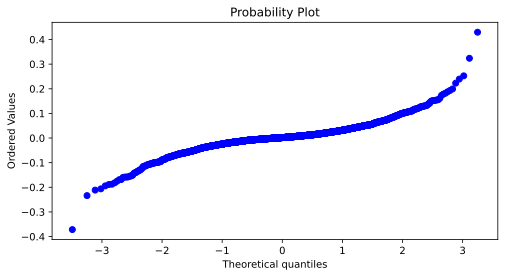

In [76]:
from scipy import stats
from scipy.stats import probplot


daily_changes = BTC['close'].pct_change(periods=1).values

figure = plt.figure(figsize=(8,4))
ax = figure.add_subplot(111)
osm, osr = stats.probplot(daily_changes, dist='norm', plot=ax, fit=True)
plt.show()

The data seems to be well correllated between quantiles -1 and 1, but not outside of this interval. There is both positive and negative skew at the ends.

## Correlation matrix

“Correlation is a statistical association of how closely two variables have a linear relationship with each other. We can perform a correlation calculation on the returns of two time series datasets to give us a value between -1 and 1. A correlation value of 0 indicates that the returns of the two time series have no relation to each other. A high correlation value close to 1 indicates that the returns of the two time series data tend to move together. A low value close to -1 indicates that returns tend to move inversely in relation to each other.”

Excerpt From: James Ma Weiming. “Mastering Python for Finance - Second Edition.” Apple Books. 

**Remember: Correlation does not imply causation!**

Let us first get some more cryptocurrencies.

In [203]:
def load_coins():
    folder = f'../02.Prepared_data/2021-04-05/'

    ETH = pd.read_csv(f"{folder}/ETH_Ethereum.csv", index_col=0, parse_dates=['date'])
    XMR = pd.read_csv(f"{folder}/XMR_Monero.csv", index_col=0, parse_dates=['date'])
    DASH = pd.read_csv(f"{folder}/DASH_Dash.csv", index_col=0, parse_dates=['date'])
    LTC = pd.read_csv(f"{folder}/LTC_Litecoin.csv", index_col=0, parse_dates=['date'])
    XRP = pd.read_csv(f"{folder}/XRP_XRP.csv", index_col=0, parse_dates=['date'])
    ADA = pd.read_csv(f"{folder}/ADA_Cardano.csv", index_col=0, parse_dates=['date'])
    DOT = pd.read_csv(f"{folder}/DOT_Polkadot.csv", index_col=0, parse_dates=['date'])

    coins = [ETH, XMR, DASH, LTC, XRP, ADA, DOT]
    # make sure that all have date as index
    new_coins = []
    for df in coins:
        df = df.sort_values(by='date')
        df = df.drop_duplicates(subset='date', keep='first')
        df = df.set_index('date', drop=True)
        new_coins.append(df)

    coins = [BTC] + new_coins

    cols = ['BTC', 'ETH', 'XMR', 'DASH', 'LTC', 'XRP', 'ADA', 'DOT']
    df = pd.DataFrame()

    for col, coin in zip(cols, coins):
        vals = coin['close'].asfreq('D', method='ffill') # in case there were some skipped days
        df[col] = vals
        
    return df

df = load_coins()
df.tail()

,BTC,ETH,XMR,DASH,LTC,XRP,ADA,DOT
date,,,,,,,,
2021-03-28,55950.75,1691.36,233.97,207.05,185.03,0.5508,1.19,32.30
2021-03-29,57750.20,1819.68,234.81,214.63,194.47,0.5679,1.20,34.37
2021-03-30,58917.69,1846.03,245.47,216.65,196.68,0.5669,1.21,34.07
2021-03-31,58918.83,1918.36,246.15,222.54,197.50,0.5739,1.19,37.03
2021-04-01,59095.81,1977.28,252.50,234.10,204.11,0.5793,1.19,37.67


In [170]:
abs_min = df['BTC'].index[0]
for c in df.columns:
    # first non NaN
    mask = df[c] > 0
    min_date = df[c][mask].index.min()
    if min_date > abs_min:
        abs_min = min_date
    print(f"Starting day for coin {c} is: {min_date.strftime('%Y-%m-%d')}")

Starting day for coin BTC is: 2013-04-29
Starting day for coin ETH is: 2015-08-07
Starting day for coin XMR is: 2014-05-21
Starting day for coin DASH is: 2014-02-14
Starting day for coin LTC is: 2013-04-29
Starting day for coin XRP is: 2013-08-04
Starting day for coin ADA is: 2017-10-01
Starting day for coin DOT is: 2020-08-22


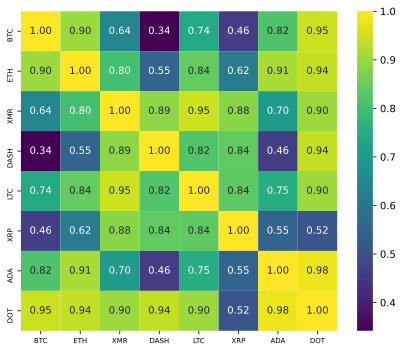

In [171]:
fig, ax = plt.subplots(figsize=(6,5))
sns.heatmap(df.corr(), ax=ax, annot=True, cmap='viridis', fmt="0.2f");
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.tight_layout()
plt.show()

We can see that there is some strong positive correlation especially between DOT and other coins except for XRP. DASH seems to be uncorrelated to BTC. This could be an interesting staring point for further investigations.


Here we have to keep in mind that some time series start at different point in times. The result looks a lot different if we start all series at the starting day of DOT.

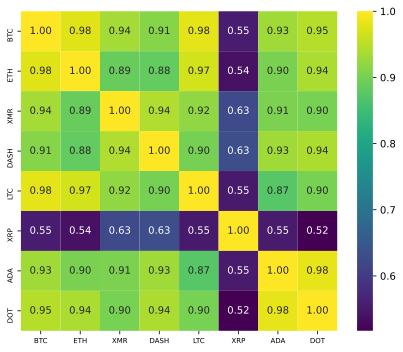

In [174]:
fig, ax = plt.subplots(figsize=(6,5))
sns.heatmap(df.loc[abs_min:, :].corr(), ax=ax, annot=True, cmap='viridis', fmt="0.2f");
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.tight_layout()
plt.show()

Note that this correlation matrix is only for the past couple of months since August 2020!

### Plotting Correlation

Correlation can also be considered over some rolling time interval. Let's take all the coins except DOT and set the start to the ADA time series starting point.

In [177]:
start = '2017-10-01'
df = df.loc[start:, :]
df = df.drop(columns='DOT')
df.head()

,BTC,ETH,XMR,DASH,LTC,XRP,ADA
date,,,,,,,
2017-10-01,4403.74,302.34,93.22,315.80,54.54,0.206532,0.024969
2017-10-02,4409.32,297.48,91.54,308.68,53.38,0.202676,0.025932
2017-10-03,4317.48,292.46,92.96,296.23,52.35,0.203318,0.020816
2017-10-04,4229.36,292.66,90.41,305.46,51.40,0.214774,0.021931
2017-10-05,4328.41,295.86,91.86,305.40,51.67,0.237016,0.021489


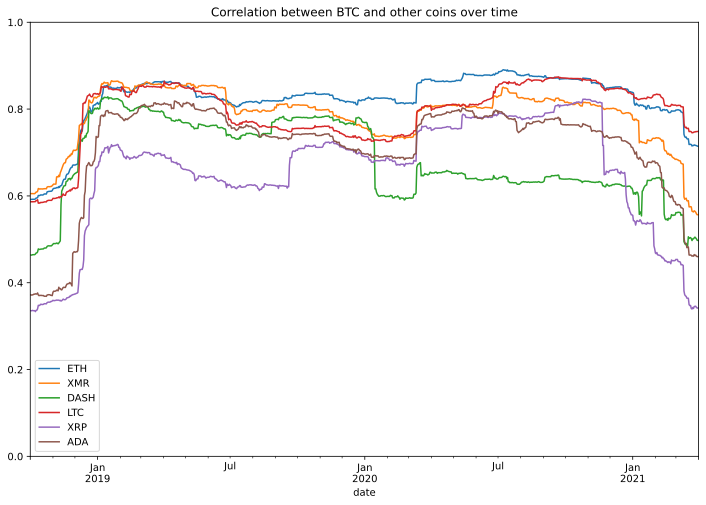

In [199]:
for coin in df.columns.tolist()[1::]:
    df = df.asfreq('D', method='ffill')
    daily_changes= df.pct_change()
    BTC_returns = daily_changes['BTC']
    OTHER_returns = daily_changes[coin]
    window = 365
    df_corrs = BTC_returns\
        .rolling(window=window, min_periods=window)\
        .corr(other=OTHER_returns)\
        .dropna()
    df_corrs.plot(figsize=(12,8), label=f'{coin}')

plt.title("Correlation between BTC and other coins over time")
plt.ylim(0, 1)
plt.legend()
plt.show()

The window is set to perform a one year rolling correlation. We can see that there is a largely strong positive correlation between BTC and ETH since the start of the period (which is shifted by one year due to the command of min_periods).

Generally there is considered strong correlation above values of around 0.7, which is true for most of the coins with BTC except for notably DASH and we see a drop in correlation coefficient in the early months of 2021, the largest being with XRP.

## Simple Moving Averages (SMA)

“A common technical indicator for time series data analysis is moving averages. The mean() method can be used to compute the mean of values for a given window in the rolling() command. For example, a 5-day Simple Moving Average (SMA) is the average of prices for the last five trading days, computed daily over a time period. Similarly, we can also compute a longer term 30-day simple moving average. These two moving averages can be used together to generate crossover signals.”

$$\textrm{SMA}=\frac{N-\Sigma \left( x_i\right)}{N}$$

where $N$ is the number of days in a given period and $\Sigma \left( x_i\right)$ is the sum of the closing prices $x_i$ for that period.

Excerpt From: James Ma Weiming. “Mastering Python for Finance - Second Edition.” Apple Books. 

In the crypto world, the metric of the 200 weeks moving average (200 WMA) is popular because the bitcoin halving occurs every 4 years and 1 year has about 50 weeks, thus $50 \cdot 4 = 200$. Analysts commonly use other window sizes, yet, they sometimes seem to chose the window size to fit their narrative. We are going to return to SMA and other average metrics later when analyzing crypto prices more carefully. For now, let's stick with learning the basics.

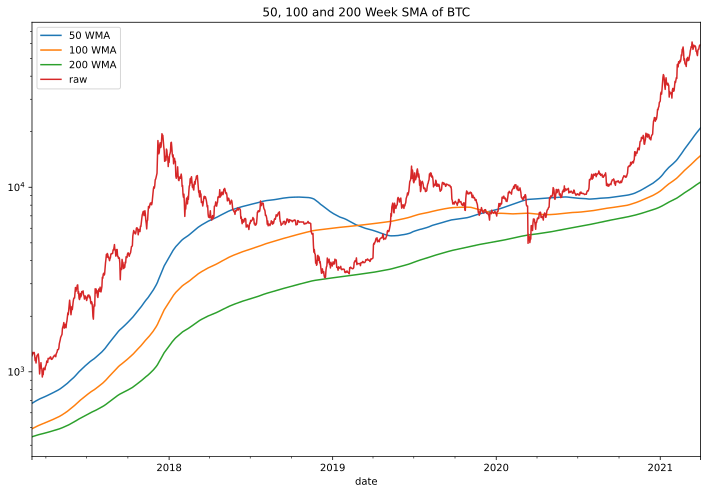

In [222]:
df = load_coins()

df = df.asfreq('D', method='ffill')

window = 200*7
SMA_200W = df['BTC'].rolling(window=window, min_periods=window).mean()

window = 100*7
SMA_100W = df['BTC'].rolling(window=window, min_periods=window).mean()

window = 50*7
SMA_50W = df['BTC'].rolling(window=window, min_periods=window).mean()

df_sma = pd.DataFrame(columns=['50 WMA', '100 WMA', '200 WMA'])
df_sma['200 WMA'] = SMA_200W
df_sma['100 WMA'] = SMA_100W
df_sma['50 WMA'] = SMA_50W
df_sma = df_sma.loc['2017-03-01':,:]
df_sma.plot(figsize=(12, 8))

df = df.loc['2017-03-01':,:]
df['BTC'].plot(label='raw')
plt.legend()
plt.title('50, 100 and 200 Week SMA of BTC')
plt.yscale('log')
plt.show()


## Exponential Moving Averages (EMA)

Contrary to the simple moving average (SMA), the exponential moving average (EMA) assigns higher weight to more recent prices (based on an exponential basis). Since new data carries greater weight, the EMA responds more quickly to price changes than the SMA.

The EMA is calculated recursively (https://en.wikipedia.org/wiki/Moving_average#Relationship_between_SMA_and_EMA):

$$EMA_t = \alpha \cdot x_t + (1-\alpha) \cdot EMA_{t-1}$$

Where:

- $\alpha$ represents the degree of weighting decrease, a constant smoothing factor between 0 and 1. A higher value discounts older observations faster.
- $x_t$ is the value at a time period t.
- $EMA_t$ is the value of the EMA at any time period t.
- The starting point for $t=0$ can be either the first value of the time series, or some SMA (see Wikipedia for some techniques)

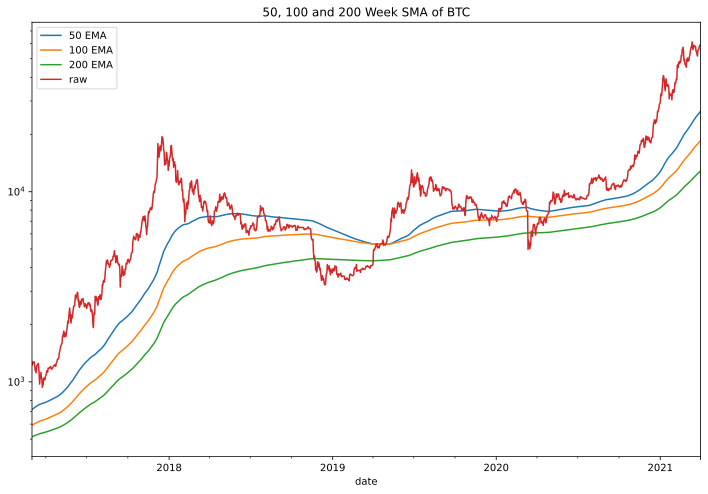

In [223]:
df = load_coins()

df = df.asfreq('D', method='ffill')

window = 200*7
EMA_200W = df['BTC'].ewm(span=window).mean()

window = 100*7
EMA_100W = df['BTC'].ewm(span=window).mean()

window = 50*7
EMA_50W = df['BTC'].ewm(span=window).mean()

df_ema = pd.DataFrame(columns=['50 EMA', '100 EMA', '200 EMA'])
df_ema['200 EMA'] = EMA_200W
df_ema['100 EMA'] = EMA_100W
df_ema['50 EMA'] = EMA_50W
df_ema = df_ema.loc['2017-03-01':,:]
df_ema.plot(figsize=(12, 8))

df = df.loc['2017-03-01':,:]
df['BTC'].plot(label='raw')
plt.legend()
plt.title('50, 100 and 200 Week EMA of BTC')
plt.yscale('log')
plt.show()

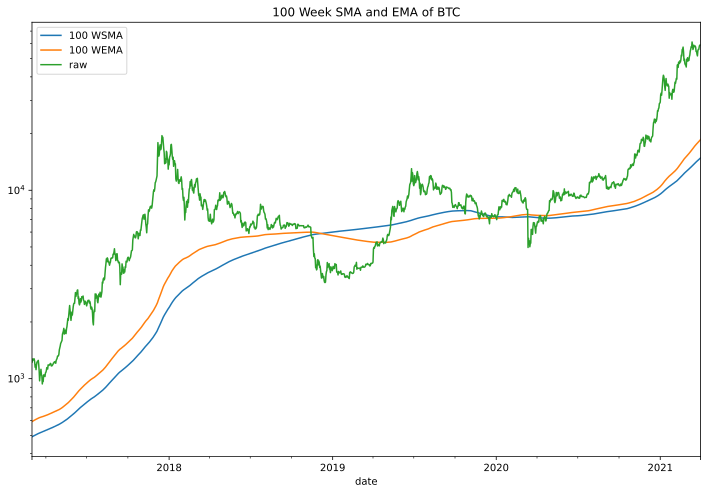

In [224]:
df = load_coins()

df = df.asfreq('D', method='ffill')

window = 100*7
SMA_100W = df['BTC'].rolling(window=window, min_periods=window).mean()

window = 100*7
EMA_100W = df['BTC'].ewm(span=window).mean()

df_ema = pd.DataFrame(columns=['100 WSMA', '100 WEMA'])
df_ema['100 WSMA'] = SMA_100W
df_ema['100 WEMA'] = EMA_100W
df_ema = df_ema.loc['2017-03-01':,:]
df_ema.plot(figsize=(12, 8))

df = df.loc['2017-03-01':,:]
df['BTC'].plot(label='raw')
plt.legend()
plt.title('100 Week SMA and EMA of BTC')
plt.yscale('log')
plt.show()

We see that the EMA and SMA follow the same trend, but the EMA is more reactive to price changes compared to the SMA.